In [194]:
import json
from typing import List

import jsonlines
import pandas as pd

with jsonlines.open('../data/politician_tweetdata.jsonl') as reader:
    raw_politician_tweets = list(reader)

with open('../data/politicians.json') as file:
    raw_politicians = json.load(file)

In [195]:
from datetime import datetime


def parse_twitter_datetime(dt: str):
    return datetime.strptime(dt, '%a %b %d %H:%M:%S +0000 %Y')


tweet_df = pd.DataFrame(data={
    'tweet': [t['full_text'] for t in raw_politician_tweets],
    'author': [t['user']['screen_name'] for t in raw_politician_tweets],
    'date': [parse_twitter_datetime(t['created_at']) for t in raw_politician_tweets],
    'id': [t['id'] for t in raw_politician_tweets]
})
tweet_df

,tweet,author,date,id
0,https://t.co/OQIM0vNzg0,MarshaBlackburn,2021-04-20 00:11:23,1384298614348865547
1,.@JoeBiden :”The problem was that the refugee ...,MarshaBlackburn,2021-04-19 21:20:43,1384255663681929219
2,Sending a heartfelt congratulations to Cerelyn...,MarshaBlackburn,2021-04-19 19:41:53,1384230791157194752
3,One person one vote should be preserved. \n \n...,MarshaBlackburn,2021-04-19 17:52:10,1384203182079758340
4,Be sure to tune in!📻 @foxnewsradio https://t.c...,MarshaBlackburn,2021-04-19 17:35:55,1384199093988167688
...,...,...,...,...
12150,Decentralize.,justinamash,2021-03-19 02:48:54,1372741843146973188
12151,Duplicating state criminal laws at the federal...,justinamash,2021-03-18 17:23:11,1372599477123608580
12152,RT @WUnrepresented: Featuring luminaries and l...,justinamash,2021-03-16 19:39:04,1371908895787089921
12153,Honored and excited to engage with fantastic @...,justinamash,2021-03-16 16:38:24,1371863431528259598


In [196]:
politician_handles = [
    {
        'handle': handle['handle'],
        'handle_type': handle['name'],
        'name': p['name'],
        'party': p['party'],
        'lgbt_stance': p['vote_match'][2]
    }
    for p in raw_politicians for handle in p['twitters']
]

politician_df = pd.DataFrame.from_dict(politician_handles)
politician_df

,handle,handle_type,name,party,lgbt_stance
0,MarshaBlackburn,Official Twitter,Marsha Blackburn,Republican,0
1,pattymurray,Official Twitter,Patty Murray,Democratic,4
2,DonBeyerVA,Don Beyer Twitter feed,Sander Levin,Democratic,4
3,PeteSessions,Official Twitter,Pete Sessions,Republican,0
4,SessionsTX17,Campaign Twitter,Pete Sessions,Republican,0
...,...,...,...,...,...
198,wydenfororegon,Campaign Twitter,Ron Wyden,Democratic,4
199,joesestak,Campaign Twitter,Joe Sestak,Democratic,4
200,amashoffice,Official Twitter,Justin Amash,Libertarian,0
201,teamamash,Campaign Twitter,Justin Amash,Libertarian,0


In [197]:
politician_df['handle_type'].value_counts()

Official Twitter          80
Campaign Twitter          66
Twitter                   29
Personal Twitter          16
Don Beyer Twitter feed    11
Twitter feed               1
Name: handle_type, dtype: int64

In [198]:
politician_df = politician_df[politician_df['handle_type'] != 'Don Beyer Twitter feed']

In [199]:
tweet_df = tweet_df.merge(politician_df, left_on='author', right_on='handle')

In [200]:
import string
import nltk
import numpy as np
from nltk import TweetTokenizer

nltk.download('stopwords')

# Build stopword set
stop = set()
stop.update(nltk.corpus.stopwords.words('english'))
stop.update(nltk.corpus.stopwords.words('spanish'))
stop.update(string.punctuation)

# Some twitter-specific ones
stop.update(['rt', '-', 'u'])


def sublist_replacement(original, old, new):
    """Replaces a sublist with another list."""
    output = []

    def is_match(i):
        if len(original) - i < len(old):
            return False
        for j in range(len(old)):
            if original[i + j] != old[j]:
                return False
        return True

    i = 0
    while i < len(original):
        if is_match(i):
            output.extend(new)
            i += len(old)
        else:
            output.append(original[i])
            i += 1

    return output

sublist_replacement(
    ['foo', 'bar', 'spam', 'memes', 'foo', 'bar', 'spam', 'memes'],
    ['bar', 'spam', 'memes'],
    ['eggs', 'ham']
)

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['foo', 'eggs', 'ham', 'foo', 'eggs', 'ham']

In [201]:
def clean_tweet_tokens(token_list):
    token_list = sublist_replacement(token_list, ['covid', '-', '19'], ['covid*'])
    token_list = sublist_replacement(token_list, ['covid', '19'], ['covid*'])
    token_list = sublist_replacement(token_list, ['covid'], ['covid*'])
    token_list = sublist_replacement(token_list, ['bears', 'ears'], ['bears ears'])
    return token_list

def tokenize_tweets(tweets, stopwords, ngram_size=1):
    tokenizer = TweetTokenizer()
    for tweet in tweets:
        tokens = list(tokenizer.tokenize(tweet))
        tokens = [
            tok
            for tok in clean_tweet_tokens(tokens)
            if tok not in stopwords
        ]

        tokens = list(nltk.ngrams(tokens, ngram_size))
        yield tokens


def tokenize_tweets_and_flatten(tweets, ngram_size=1):
    tokenized_tweets = tokenize_tweets(tweets, stop, ngram_size=ngram_size)
    return (' '.join(ngram) for tweet in tokenized_tweets for ngram in tweet)


def calculate_word_freqs(series, ngram_size=1):
    all_tokens = np.array(list(
        tokenize_tweets_and_flatten(series.str.lower(), ngram_size=ngram_size)
    ))
    tokens, counts = np.unique(all_tokens, return_counts=True)
    frequencies = pd.DataFrame(
        data={'token': tokens, 'count': counts}
    )
    frequencies.set_index('token', inplace=True)
    frequencies.sort_values('count', inplace=True, ascending=False)
    return frequencies

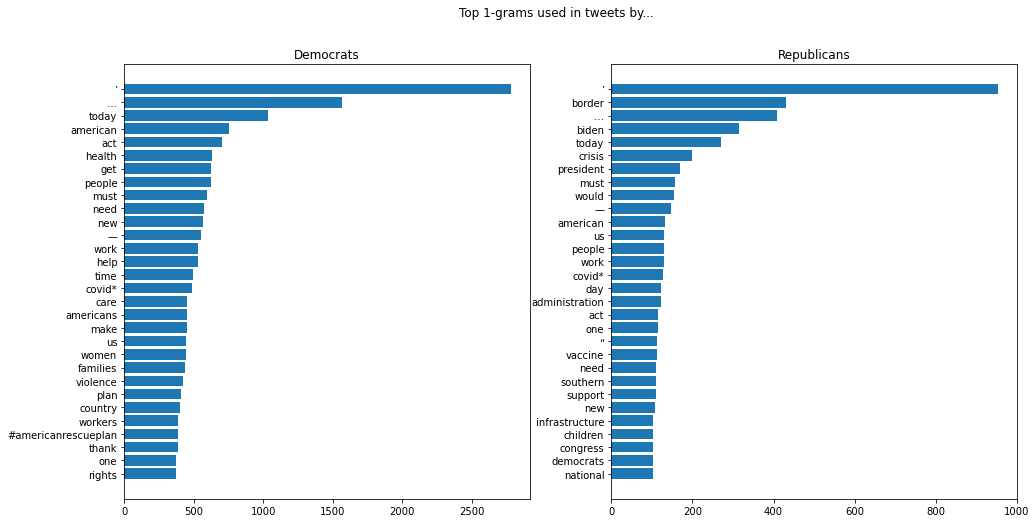

In [202]:
import matplotlib.pyplot as plt


def plot_frequencies(ax: plt.Axes, freq_series):
    top_n = freq_series.iloc[:30]
    ax.barh(top_n.index, top_n)
    ax.invert_yaxis()


def plot_ngrams(ax, tweet_series, ngram_size=1):
    frequency_df = calculate_word_freqs(tweet_series, ngram_size=ngram_size)
    plot_frequencies(ax, frequency_df['count'])


def plot_parties(tweet_df, ngram_size):
    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(16, 8))

    fig.suptitle(f'Top {ngram_size}-grams used in tweets by...')

    ax_l.set_title('Democrats')
    plot_ngrams(ax_l, tweet_df[tweet_df['party'] == 'Democratic']['tweet'], ngram_size)

    ax_r.set_title('Republicans')
    plot_ngrams(ax_r, tweet_df[tweet_df['party'] == 'Republican']['tweet'], ngram_size)


plot_parties(tweet_df, 1)
plt.show()

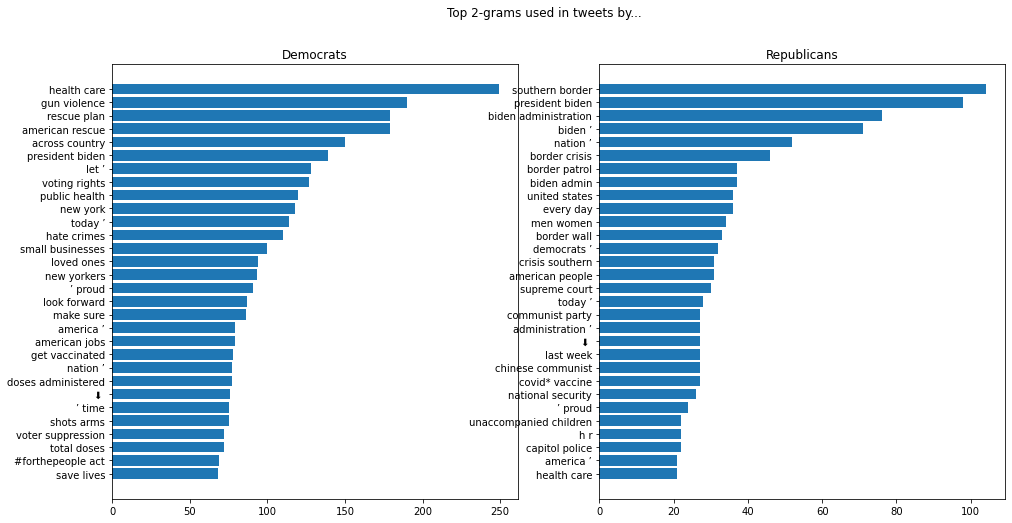

In [203]:
plot_parties(tweet_df, 2)
plt.show()

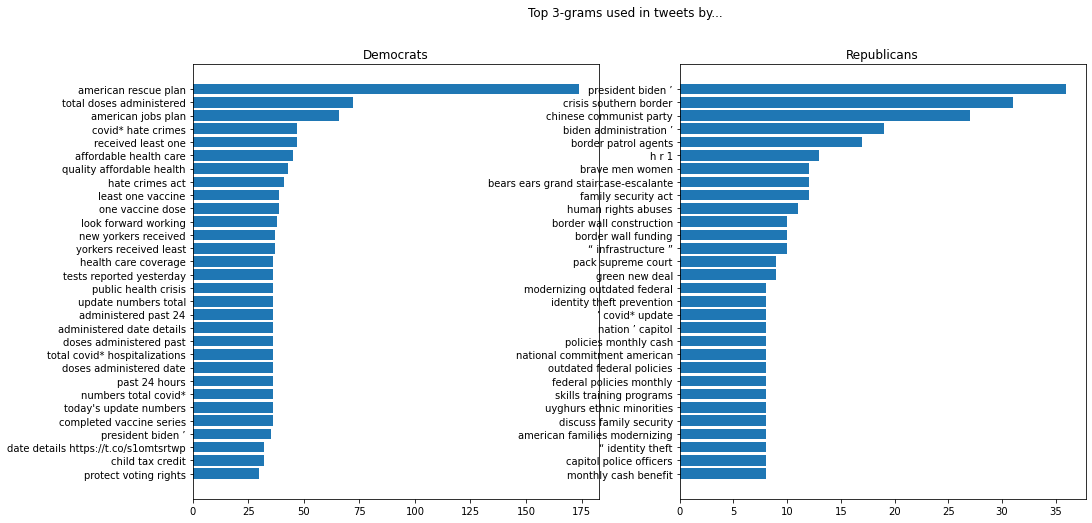

In [204]:
plot_parties(tweet_df, 3)
plt.show()